In [1]:
# Import denpendecies
import requests
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import BalancedBaggingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Define a list of table names and their corresponding API endpoints
tables = {
            
        "Bureau" : 'http://127.0.0.1:5000/bureau',
        "Bureau_balance" : 'http://127.0.0.1:5000/bureau_balance',
        "Credit_card_balance" : 'http://127.0.0.1:5000/credit_card_balance',
        "Installments_payments" : 'http://127.0.0.1:5000/installments_payments',
        "POS_CASH_balance" : 'http://127.0.0.1:5000/pOS_CASH_balance',
        "Previous_application" : 'http://127.0.0.1:5000/previous_application',
        "Application_train" : 'http://127.0.0.1:5000/application_train'
}

# Dictionary to store DataFrames for each table
dataframes = {}

# Make API requests to get data from each table
for table_name, endpoint in tables.items():
    response = requests.get(endpoint)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Convert API response to a DataFrame and store it in the dictionary
        dataframes[table_name] = pd.DataFrame(response.json())
        print(f"Data for {table_name} fetched successfully.")
    else:
        print(f"Error: Unable to fetch data from {table_name}. Status code: {response.status_code}")

Data for Bureau fetched successfully.
Data for Bureau_balance fetched successfully.
Data for Credit_card_balance fetched successfully.
Data for Installments_payments fetched successfully.
Data for POS_CASH_balance fetched successfully.
Data for Previous_application fetched successfully.
Data for Application_train fetched successfully.


In [18]:
# Merge tables based on specified keys
merged_table = dataframes["Application_train"]

# Merge POS_CASH_balance, Installments_payments, Credit_card_balance based on SK_ID_PREV
for table_name in ["POS_CASH_balance", "Installments_payments", "Credit_card_balance", "Previous_application"]:
    if table_name in dataframes:
        # Specify suffixes to avoid duplicate column names
        merged_table = pd.merge(merged_table, dataframes[table_name], on='SK_ID_CURR', how='left', suffixes=('', f'_{table_name}'))

# Merge Bureau and Bureau_balance based on SK_ID_BUREAU
if "Bureau" in dataframes and "Bureau_balance" in dataframes:
    bureau_merged = pd.merge(dataframes["Bureau"], dataframes["Bureau_balance"], on='SK_ID_BUREAU', how='left', suffixes=('_bureau', '_bureau_balance'))
    merged_table = pd.merge(merged_table, bureau_merged, on='SK_ID_CURR', how='left')

# Display the final merged table with unique columns
unique_columns = merged_table.columns.unique()
final_table = merged_table[unique_columns]

# Display the final table
print(final_table.head())

   AMT_ANNUITY_x  AMT_CREDIT  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  \
0        29970.0    640080.0         450000.0          180000.0   
1        11695.5    215640.0         180000.0           69750.0   
2        11695.5    215640.0         180000.0           69750.0   
3        11695.5    215640.0         180000.0           69750.0   
4        11695.5    215640.0         180000.0           69750.0   

   AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_HOUR  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        0.0                         0.0   
4                        0.0                         0.0   

   AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   


In [4]:
# Drop duplicate values
data_df = final_table.drop_duplicates()

In [5]:
# Fill na with (0)
data_df=data_df.fillna(0)

In [6]:
# Changing CODE_GENDER to 0 and 1 to match model
data_df['CODE_GENDER'] = data_df['CODE_GENDER'].replace({'F': 0, 'M': 1})

In [10]:
# Changing FLAG_OWN_REALTY AND FLAG_OWN_CAR to 0 and 1 to match model
data_df[['FLAG_OWN_REALTY', 'FLAG_OWN_CAR']] = data_df[['FLAG_OWN_REALTY', 'FLAG_OWN_CAR']].replace({'Y': 1, 'N': 0}).astype(int)

In [14]:
# Count of Target values
data_count = data_df["TARGET"].value_counts()
print(data_count)

TARGET
0    176770
1     14780
Name: count, dtype: int64


In [8]:
# Selecting X features
X = data_df.drop(columns=['TARGET'], axis=1)

In [57]:
# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X).astype(int)

In [58]:
# select Target variable
y = data_df['TARGET'].values

### Using full features imbalanced the Data and RandomForestClassifier

In [59]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate a StandardScaler instance

scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train_scaled, y_train)

# Get probability outputs for the test set
probabilities = model.predict_proba(X_test_scaled)

# Extract the probability of the positive class (class 1)
positive_class_probabilities = probabilities[:, 1]

# Define a threshold to make binary predictions
threshold = 0.5
binary_predictions = (positive_class_probabilities > threshold).astype(int)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions)

# Print the confusion matrix and accuracy
print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy:", accuracy)

Confusion Matrix:
[[31085     0]
 [ 1661   899]]

Accuracy: 0.9506315945905781


In [109]:
report = classification_report_imbalanced(y_test, binary_predictions,target_names=["Low Risk","High Risk"])
print("\nImbalanced Classification Report RandomForest:")
print(report)


Imbalanced Classification Report RandomForest:
                   pre       rec       spe        f1       geo       iba       sup

   Low Risk       0.95      1.00      0.35      0.97      0.59      0.37     31085
  High Risk       1.00      0.35      1.00      0.52      0.59      0.33      2560

avg / total       0.95      0.95      0.40      0.94      0.59      0.37     33645



In [61]:
# Extract the probability of the positive class (class 1)
positive_class_probabilities = probabilities[:, 1]

# Define custom thresholds for each class
thresholds = [0.2, 0.4, 0.6, 0.8]

# Classify into 5 classes based on custom thresholds
risk_levels = pd.cut(positive_class_probabilities, bins=[-float('inf')] + thresholds + [float('inf')],
                     labels=['Very Low Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk'], include_lowest=True)

# Create a DataFrame with 'SK_ID_CURR', probability, and risk level
result_df = pd.DataFrame({'SK_ID_CURR': X_test['SK_ID_CURR'],'Probability': positive_class_probabilities, 'Risk Level': risk_levels})
result_df.sort_values(by='SK_ID_CURR', ascending=True, inplace=True)
result_df = result_df.drop_duplicates()
result_df = result_df.reset_index(drop=True)
# Print the result DataFrame
print(result_df)

       SK_ID_CURR  Probability     Risk Level
0          294883         0.21       Low Risk
1          294895         0.25       Low Risk
2          294905         0.05  Very Low Risk
3          294905         0.02  Very Low Risk
4          294914         0.13  Very Low Risk
...           ...          ...            ...
28402      410651         0.10  Very Low Risk
28403      410653         0.30       Low Risk
28404      410656         0.10  Very Low Risk
28405      410662         0.10  Very Low Risk
28406      410665         0.02  Very Low Risk

[28407 rows x 3 columns]


In [14]:
# Random Forests in sklearn will automatically calculate feature importance
importances = model.feature_importances_
# We can sort the features by their importance
importances_sorted = sorted(zip(model.feature_importances_, X.columns), reverse=True)
importances_sorted = importances_sorted[:30]
sorted_df = pd.DataFrame(importances_sorted)
sorted_df[1]

0                           DAYS_BIRTH
1                      DAYS_ID_PUBLISH
2                    DAYS_REGISTRATION
3               DAYS_LAST_PHONE_CHANGE
4                        AMT_ANNUITY_x
5                           SK_ID_CURR
6                           AMT_CREDIT
7                        DAYS_EMPLOYED
8                     AMT_INCOME_TOTAL
9                      AMT_GOODS_PRICE
10             HOUR_APPR_PROCESS_START
11          AMT_REQ_CREDIT_BUREAU_YEAR
12                         OWN_CAR_AGE
13    SK_ID_PREV_Installments_payments
14            OBS_60_CNT_SOCIAL_CIRCLE
15            OBS_30_CNT_SOCIAL_CIRCLE
16      SK_ID_PREV_Credit_card_balance
17                     DAYS_INSTALMENT
18                         AMT_PAYMENT
19                  DAYS_ENTRY_PAYMENT
20                      AMT_INSTALMENT
21                     CNT_FAM_MEMBERS
22               NUM_INSTALMENT_NUMBER
23                          SK_ID_PREV
24                    MONTHS_BALANCE_x
25               CNT_INST

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

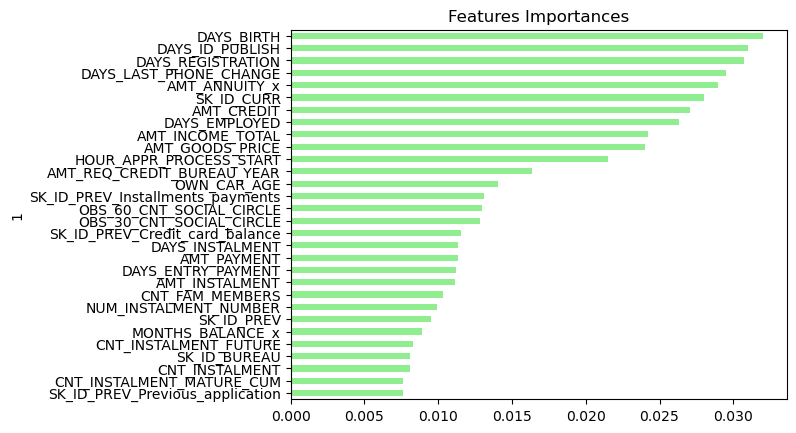

In [15]:
sorted_df.set_index(sorted_df[1], inplace=True)
sorted_df.drop(columns=1, inplace=True)
sorted_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = sorted_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

In [62]:
X  = data_df[["DAYS_ID_PUBLISH",
                           "DAYS_BIRTH",
                      "DAYS_REGISTRATION",
                 "DAYS_LAST_PHONE_CHANGE",
                          "AMT_ANNUITY_x",
                             "SK_ID_CURR",
                             "AMT_CREDIT",
                          "DAYS_EMPLOYED",
                        "AMT_GOODS_PRICE",
                       "AMT_INCOME_TOTAL",
               "HOUR_APPR_PROCESS_START",
            "AMT_REQ_CREDIT_BUREAU_YEAR",
                           "OWN_CAR_AGE",
              "OBS_30_CNT_SOCIAL_CIRCLE",
              "OBS_60_CNT_SOCIAL_CIRCLE",
                           "AMT_PAYMENT",
                    "DAYS_ENTRY_PAYMENT",
                        "AMT_INSTALMENT",
                       "DAYS_INSTALMENT",
                 "NUM_INSTALMENT_NUMBER",
                 "CNT_INSTALMENT_FUTURE",
                      "MONTHS_BALANCE_x",
                       "CNT_FAM_MEMBERS",
                        "CNT_INSTALMENT",
             "CNT_INSTALMENT_MATURE_CUM",
    "MONTHS_BALANCE_Credit_card_balance"]]

In [63]:
# Fillna (0) in the selective features
X_features = X.fillna(0)

In [64]:
# Selective target variable
y_features = data_df['TARGET']

### Using selective features imbalanced the Data and RandomForestClassifier

In [65]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y_features, test_size=0.2, random_state=42)

# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

# Initialize the RandomForestClassifier
model_features = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model_features.fit(X_train_scaled, y_train)

# Get probability outputs for the test set
probabilities_features = model_features.predict_proba(X_test_scaled)

# Extract the probability of the positive class (class 1)
positive_class_probabilities_features = probabilities_features[:, 1]

# Define a threshold to make binary predictions
threshold = 0.5
binary_predictions_features = (positive_class_probabilities_features > threshold).astype(int)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions_features)

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions_features)

# Print the confusion matrix and accuracy
print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy:", accuracy)

Confusion Matrix:
[[31085     0]
 [ 1480  1080]]

Accuracy: 0.9560112943973844


In [110]:
report = classification_report_imbalanced(y_test, binary_predictions_features,target_names=["Low Risk", "High Risk"])
print("\nImbalanced Classification Report RandomForest:")
print(report)


Imbalanced Classification Report RandomForest:
                   pre       rec       spe        f1       geo       iba       sup

   Low Risk       0.96      0.99      0.46      0.98      0.67      0.48     31085
  High Risk       0.87      0.46      0.99      0.60      0.67      0.43      2560

avg / total       0.95      0.95      0.50      0.95      0.67      0.47     33645



In [76]:
# Extract the probability of the positive class (class 1)
positive_class_probabilities_features = probabilities_features[:, 1]

# Define custom thresholds for each class
thresholds = [0.2, 0.4, 0.6, 0.8]

# Classify into 5 classes based on custom thresholds
risk_levels_features = pd.cut(positive_class_probabilities_features, bins=[-float('inf')] + thresholds + [float('inf')],
                     labels=['Very Low Risk', 'Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk'], include_lowest=True)

# Create a DataFrame with 'SK_ID_CURR', probability, and risk level
result_df_features = pd.DataFrame({'SK_ID_CURR': X_test['SK_ID_CURR'],'Probability': positive_class_probabilities_features, 'Risk Level': risk_levels_features})
result_df_features.sort_values(by='SK_ID_CURR', ascending=True, inplace=True)
result_df_features = result_df_features.drop_duplicates()
result_df_features = result_df_features.reset_index(drop=True)
# Print the result DataFrame
print(result_df_features)

       SK_ID_CURR  Probability     Risk Level
0          294883     0.222817       Low Risk
1          294895     0.220472       Low Risk
2          294905     0.114998  Very Low Risk
3          294905     0.136797  Very Low Risk
4          294914     0.283879       Low Risk
...           ...          ...            ...
27045      410651     0.196957  Very Low Risk
27046      410653     0.220811       Low Risk
27047      410656     0.417942    Medium Risk
27048      410662     0.397325       Low Risk
27049      410665     0.222467       Low Risk

[27050 rows x 3 columns]


In [1]:
import joblib
joblib.dump(model_features, 'model_probability_features.joblib')

NameError: name 'model_features' is not defined

In [77]:
# Selecting features to train the model
X  = data_df[["DAYS_ID_PUBLISH",
                           "DAYS_BIRTH",
                      "DAYS_REGISTRATION",
                 "DAYS_LAST_PHONE_CHANGE",
                          "AMT_ANNUITY_x",
                             "SK_ID_CURR",
                             "AMT_CREDIT",
                          "DAYS_EMPLOYED",
                        "AMT_GOODS_PRICE",
                       "AMT_INCOME_TOTAL",
               "HOUR_APPR_PROCESS_START",
            "AMT_REQ_CREDIT_BUREAU_YEAR",
                           "OWN_CAR_AGE",
              "OBS_30_CNT_SOCIAL_CIRCLE",
              "OBS_60_CNT_SOCIAL_CIRCLE",
                           "AMT_PAYMENT",
                    "DAYS_ENTRY_PAYMENT",
                        "AMT_INSTALMENT",
                       "DAYS_INSTALMENT",
                 "NUM_INSTALMENT_NUMBER",
                 "CNT_INSTALMENT_FUTURE",
                      "MONTHS_BALANCE_x",
                       "CNT_FAM_MEMBERS",
                        "CNT_INSTALMENT",
             "CNT_INSTALMENT_MATURE_CUM",
    "MONTHS_BALANCE_Credit_card_balance"]]

In [78]:
# Fillna (0) in the selective features
X_features = X.fillna(0)

In [79]:
# Selective target variable
y_features = data_df['TARGET']

### Using SMOT to balance the Data and Gradient Boosting Classifier model

In [81]:
# Assuming X_features and y_features are your feature matrix and target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y_features, test_size=0.2, random_state=42)

# Use SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the resampled training data to the standard scaler
X_scaler = scaler.fit(X_train_resampled)

# Transform the resampled training data using the scaler
X_train_scaled = X_scaler.transform(X_train_resampled)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

# Initialize the GradientClassifier
model_features = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Train the model
model_features.fit(X_train_scaled, y_train_resampled)

# Get probability outputs for the test set
probabilities_features = model_features.predict_proba(X_test_scaled)

# Extract the probability of the positive class (class 1)
positive_class_probabilities_features = probabilities_features[:, 1]

# Define a threshold to make binary predictions
threshold = 0.5
binary_predictions_features = (positive_class_probabilities_features > threshold).astype(int)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions_features)

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions_features)

# Print the confusion matrix and accuracy
print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy:", accuracy)


Confusion Matrix:
[[29498  1587]
 [ 2057   503]]

Accuracy: 0.8916926735027493


In [111]:
report = classification_report_imbalanced(y_test, binary_predictions_features,target_names=["Low Risk", "High Risk"])
print("\nImbalanced Classification Report SMOT&GradientBoosting:")
print(report)


Imbalanced Classification Report SMOT&GradientBoosting:
                   pre       rec       spe        f1       geo       iba       sup

   Low Risk       0.96      0.99      0.46      0.98      0.67      0.48     31085
  High Risk       0.87      0.46      0.99      0.60      0.67      0.43      2560

avg / total       0.95      0.95      0.50      0.95      0.67      0.47     33645



### Using SMOT to balance the Data and AdaBoost Classifier model

In [124]:
# Assuming X_features and y_features are your feature matrix and target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y_features, test_size=0.2, random_state=42)

# Use SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the resampled training data to the standard scaler
X_scaler = scaler.fit(X_train_resampled)

# Transform the resampled training data using the scaler
X_train_scaled = X_scaler.transform(X_train_resampled)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

# Initialize the AdaBoostClassifier
model_features = AdaBoostClassifier(n_estimators=100, random_state=42)

# Train the model
model_features.fit(X_train_scaled, y_train_resampled)

# Get probability outputs for the test set
probabilities_features = model_features.predict_proba(X_test_scaled)

# Extract the probability of the positive class (class 1)
positive_class_probabilities_features = probabilities_features[:, 1]

# Define a threshold to make binary predictions
threshold = 0.5
binary_predictions_features = (positive_class_probabilities_features > threshold).astype(int)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions_features)

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions_features)

# Print the confusion matrix and accuracy
print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy:", accuracy)


Confusion Matrix:
[[27051  4034]
 [ 1834   726]]

Accuracy: 0.8255907267053054


In [125]:
report = classification_report_imbalanced(y_test, binary_predictions_features,target_names=["Low Risk", "High Risk"])
print("\nImbalanced Classification Report SMOT&AdaBoosting:")
print(report)


Imbalanced Classification Report SMOT&AdaBoosting:
                   pre       rec       spe        f1       geo       iba       sup

   Low Risk       0.94      0.87      0.28      0.90      0.50      0.26     31085
  High Risk       0.15      0.28      0.87      0.20      0.50      0.23      2560

avg / total       0.88      0.83      0.33      0.85      0.50      0.26     33645



### Using RandomOverSampler to balance the Data and Random Forest Classifier model

In [84]:

# Assuming X_features and y_features are your feature matrix and target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y_features, test_size=0.2, random_state=42)

# Use RandomOverSampler to oversample the minority class
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the resampled training data to the standard scaler
X_scaler = scaler.fit(X_train_resampled)

# Transform the resampled training data using the scaler
X_train_scaled = X_scaler.transform(X_train_resampled)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

# Initialize the RandomForestClassifier
model_features = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model_features.fit(X_train_scaled, y_train_resampled)

# Get probability outputs for the test set
probabilities_features = model_features.predict_proba(X_test_scaled)

# Extract the probability of the positive class (class 1)
positive_class_probabilities_features = probabilities_features[:, 1]

# Define a threshold to make binary predictions
threshold = 0.5
binary_predictions_features = (positive_class_probabilities_features > threshold).astype(int)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions_features)

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions_features)

# Print the confusion matrix and accuracy
print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy:", accuracy)


Confusion Matrix:
[[31083     2]
 [ 1413  1147]]

Accuracy: 0.9579432307920939


In [112]:
print("Imbalanced Classification Report RandomOverSampler&RandomForest:")
print(classification_report_imbalanced(y_test,binary_predictions_features,target_names=["Low Risk", "High Risk"]))

Imbalanced Classification Report RandomOverSampler&RandomForest:
                   pre       rec       spe        f1       geo       iba       sup

   Low Risk       0.96      0.99      0.46      0.98      0.67      0.48     31085
  High Risk       0.87      0.46      0.99      0.60      0.67      0.43      2560

avg / total       0.95      0.95      0.50      0.95      0.67      0.47     33645



### Using RandomOverSampler to balance the Data and Balanced Bagging Classifier model

In [87]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y_features, test_size=0.2, random_state=42)

# Use RandomOverSampler to oversample the minority class
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the resampled training data to the standard scaler
X_scaler = scaler.fit(X_train_resampled)

# Transform the resampled training data using the scaler
X_train_scaled = X_scaler.transform(X_train_resampled)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

# Create an ensemble bagging classifier using BalancedBaggingClassifier
bagging_classifier = BalancedBaggingClassifier(n_estimators=10, random_state=42)

# Train the ensemble model
bagging_classifier.fit(X_train_scaled, y_train_resampled)

# Get probability outputs for the test set
probabilities_features = bagging_classifier.predict_proba(X_test_scaled)

# Extract the probability of the positive class (class 1)
positive_class_probabilities_features = probabilities_features[:, 1]

# Define a threshold to make binary predictions
threshold = 0.5
binary_predictions_features = (positive_class_probabilities_features > threshold).astype(int)




In [113]:
# Print the imbalanced classification report
print("Imbalanced Classification Report RandomOversampler&BalancedBagging:")
print(classification_report_imbalanced(y_test, binary_predictions_features,target_names=["Low Risk", "High Risk"]))

Imbalanced Classification Report RandomOversampler&BalancedBagging:
                   pre       rec       spe        f1       geo       iba       sup

   Low Risk       0.96      0.99      0.46      0.98      0.67      0.48     31085
  High Risk       0.87      0.46      0.99      0.60      0.67      0.43      2560

avg / total       0.95      0.95      0.50      0.95      0.67      0.47     33645



## Comparative Visualization of Models Results

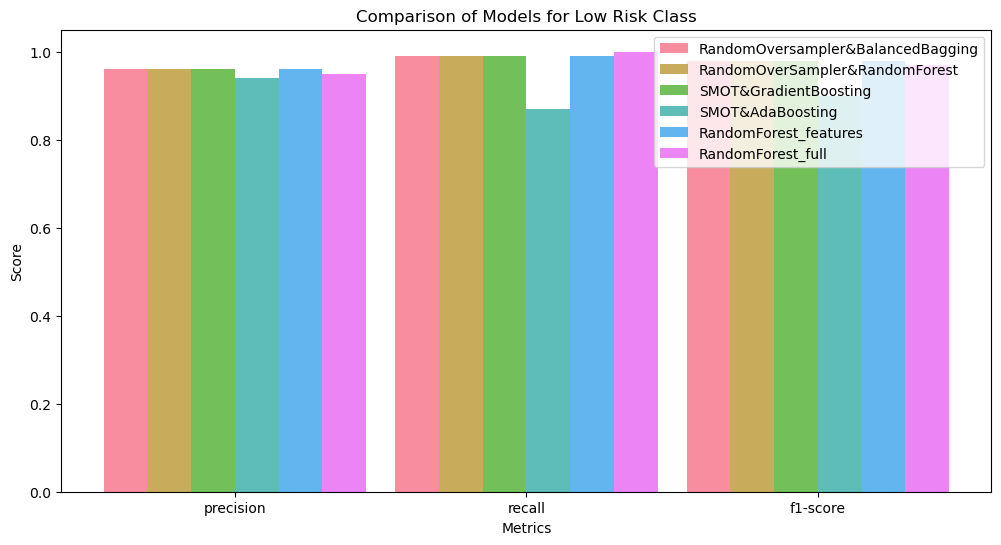

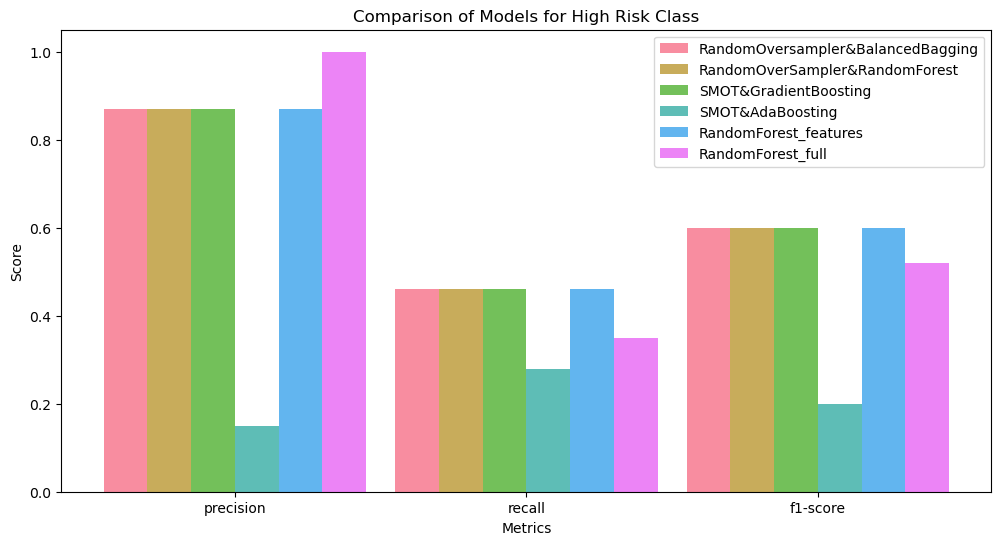

In [143]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data for different models
models_data = {
    'RandomOversampler&BalancedBagging': {'Low Risk': {'precision': 0.96, 'recall': 0.99, 'f1-score': 0.98},
                                          'High Risk': {'precision': 0.87, 'recall': 0.46, 'f1-score': 0.60}},
    'RandomOverSampler&RandomForest': {'Low Risk': {'precision': 0.96, 'recall': 0.99, 'f1-score': 0.98},
                                       'High Risk': {'precision': 0.87, 'recall': 0.46, 'f1-score': 0.60}},
    'SMOT&GradientBoosting': {'Low Risk': {'precision': 0.96, 'recall': 0.99, 'f1-score': 0.98},
                               'High Risk': {'precision': 0.87, 'recall': 0.46, 'f1-score': 0.60}},
    'SMOT&AdaBoosting': {'Low Risk': {'precision': 0.94, 'recall': 0.87, 'f1-score': 0.90},
                               'High Risk': {'precision': 0.15, 'recall': 0.28, 'f1-score': 0.20}},
    'RandomForest_features': {'Low Risk': {'precision': 0.96, 'recall': 0.99, 'f1-score': 0.98},
                      'High Risk': {'precision': 0.87, 'recall': 0.46, 'f1-score': 0.60}},
    'RandomForest_full': {'Low Risk': {'precision': 0.95, 'recall': 1.00, 'f1-score': 0.97},
                      'High Risk': {'precision': 1.00, 'recall': 0.35, 'f1-score': 0.52}},
}

# Create a Pandas DataFrame
df = pd.DataFrame({(model, risk_level): data for model, model_data in models_data.items()
                   for risk_level, data in model_data.items()})

# Plotting
bar_width = 0.15  # Decreased bar width
index = np.arange(len(metrics))

for risk_level in classes:
    plt.figure(figsize=(12, 6))  # Adjusted figure size
    
    for i, model in enumerate(models_data.keys()):
        plt.bar(index + i * bar_width, df[model, risk_level], bar_width, label=model, alpha=0.8)

    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title(f'Comparison of Models for {risk_level} Class')
    plt.xticks(index + bar_width * (len(models_data) - 1) / 2, metrics)
    plt.legend()
    plt.show()


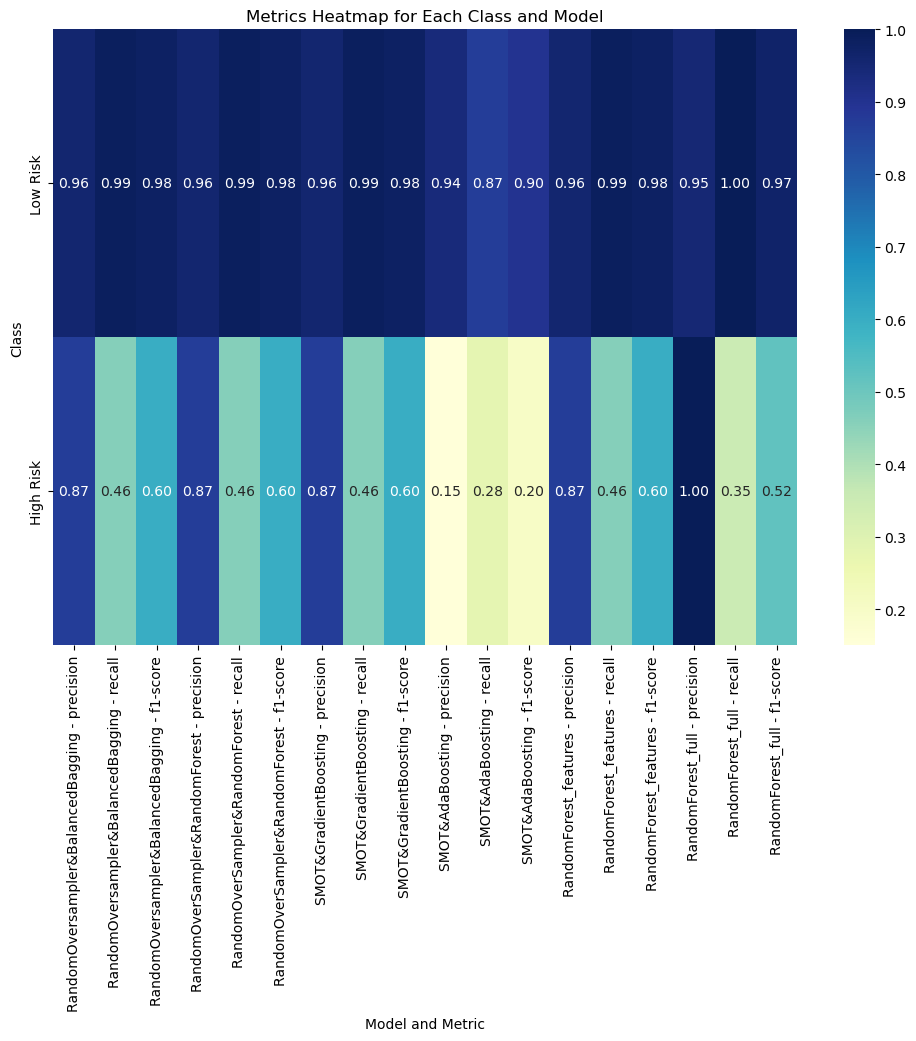

In [127]:
# Heat maps multiple models
models_data = {
    'RandomOversampler&BalancedBagging': {
        'Low Risk': {'precision': 0.96, 'recall': 0.99, 'f1-score': 0.98},
        'High Risk': {'precision': 0.87, 'recall': 0.46, 'f1-score': 0.60},
    },
    'RandomOverSampler&RandomForest': {
        'Low Risk': {'precision': 0.96, 'recall': 0.99, 'f1-score': 0.98},
        'High Risk': {'precision': 0.87, 'recall': 0.46, 'f1-score': 0.60},
    },
    'SMOT&GradientBoosting': {
        'Low Risk': {'precision': 0.96, 'recall': 0.99, 'f1-score': 0.98},
        'High Risk': {'precision': 0.87, 'recall': 0.46, 'f1-score': 0.60},
    },
    'SMOT&AdaBoosting': {
        'Low Risk': {'precision': 0.94, 'recall': 0.87, 'f1-score': 0.90},
        'High Risk': {'precision': 0.15, 'recall': 0.28, 'f1-score': 0.20},
    },
    'RandomForest_features': {
        'Low Risk': {'precision': 0.96, 'recall': 0.99, 'f1-score': 0.98},
        'High Risk': {'precision': 0.87, 'recall': 0.46, 'f1-score': 0.60},
    },
    'RandomForest_full': {
        'Low Risk': {'precision': 0.95, 'recall': 1.00, 'f1-score': 0.97},
        'High Risk': {'precision': 1.00, 'recall': 0.35, 'f1-score': 0.52},
    },
}

# Extracting classes and metrics
classes = list(next(iter(models_data.values())).keys())
metrics = ['precision', 'recall', 'f1-score']

# Create a 2D array to store metric values
heatmap_data = np.zeros((len(classes), len(models_data) * len(metrics)))

# Populate the array with metric values
for i, metric in enumerate(metrics):
    for j, (model, class_data) in enumerate(models_data.items()):
        for k, data in enumerate(class_data.values()):
            heatmap_data[k, i + j * len(metrics)] = data[metric]

# Create a heatmap using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=[f'{model} - {metric}' for model in models_data.keys() for metric in metrics],
            yticklabels=classes)

plt.xlabel('Model and Metric')
plt.ylabel('Class')
plt.title('Metrics Heatmap for Each Class and Model')
plt.show()
